# Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from statsmodels.tsa.arima.model import ARIMA

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Dataset

In [3]:
data_path = "data_raw/train.csv"
df = pd.read_csv(data_path)
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# EDA

In [4]:
df.describe()

,id,store_nbr,sales,onpromotion
count,3.000888e+06,3.000888e+06,3.000888e+06,3.000888e+06
mean,1.500444e+06,2.750000e+01,3.577757e+02,2.602770e+00
std,8.662819e+05,1.558579e+01,1.101998e+03,1.221888e+01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,7.502218e+05,1.400000e+01,0.000000e+00,0.000000e+00
50%,1.500444e+06,2.750000e+01,1.100000e+01,0.000000e+00
75%,2.250665e+06,4.100000e+01,1.958473e+02,0.000000e+00
max,3.000887e+06,5.400000e+01,1.247170e+05,7.410000e+02


In [5]:
df.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [6]:
df['date'] = pd.to_datetime(df['date'])

## Unit sales for each product

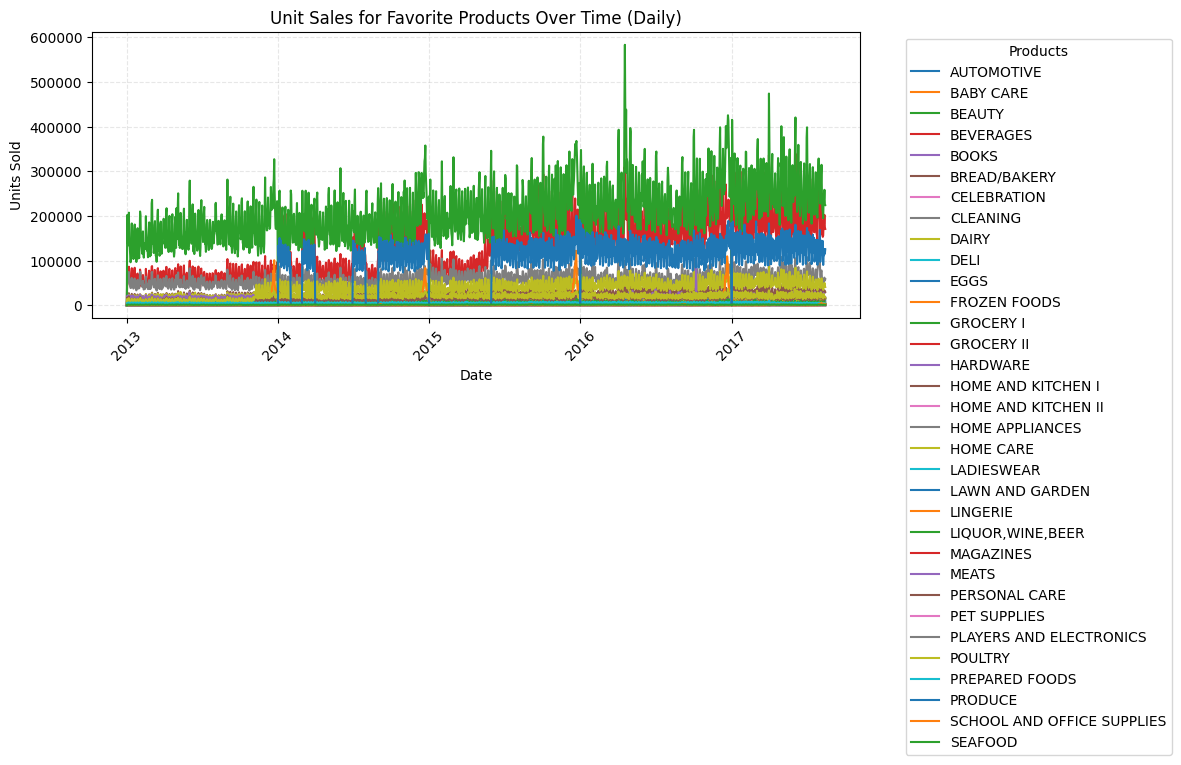

In [7]:
# Unit sales for each product

ts = (
    df.groupby([df['date'].dt.to_period("D"), 'family'])['sales']
    .sum()
    .reset_index()
)
ts['date'] = ts['date'].dt.to_timestamp()

# Plot
ts_pivot = ts.pivot(index='date', columns='family', values='sales')
plt.figure(figsize=(12,6))
for product in ts_pivot.columns:
    plt.plot(ts_pivot.index, ts_pivot[product], label=product)

plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.title("Unit Sales for Favorite Products Over Time (Daily)")
plt.legend(title="Products", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


## Seasonal Demand for each Product

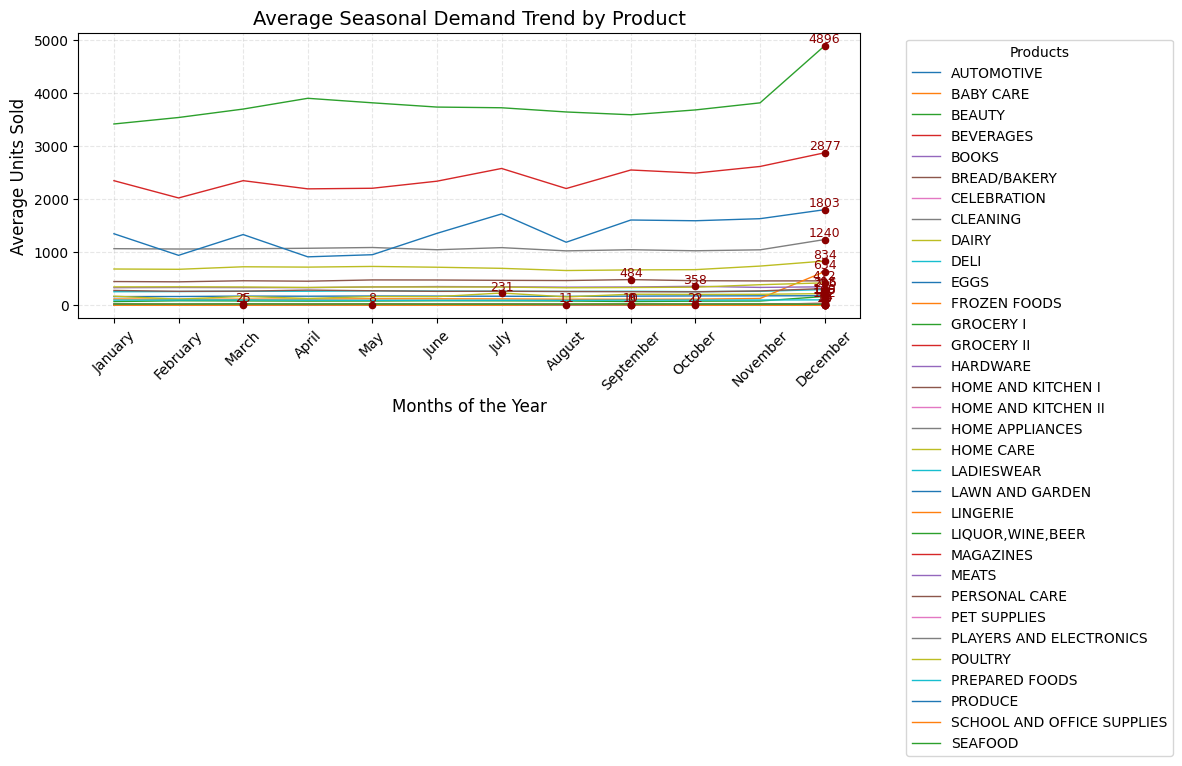

In [8]:
# Seasonal Demand for each Product

df['MonthName'] = df['date'].dt.month_name()

# Aggregate: average monthly sales per product
seasonal = (
    df.groupby(['MonthName','family'])['sales']
    .mean()
    .reset_index()
    .pivot(index='MonthName', columns='family', values='sales')
    .reindex(
        months_order := ["January","February","March","April","May","June",
                         "July","August","September","October","November","December"]
        )
    )

# Plot
plt.figure(figsize=(12,6))

for product in seasonal.columns:
    plt.plot(seasonal.index, seasonal[product], linewidth=1, label=product)

    # Find the max month + value for this product
    max_idx = seasonal[product].idxmax()
    max_val = seasonal[product].max()

    # Highlight the spike
    plt.scatter(max_idx, max_val, color="darkred", s=20, zorder=5)
    plt.text(max_idx, max_val, f"{max_val:.0f}",
             ha="center", va="bottom", fontsize=9, color="darkred")

plt.xlabel("Months of the Year", fontsize=12)
plt.ylabel("Average Units Sold", fontsize=12)
plt.title("Average Seasonal Demand Trend by Product", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Products", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


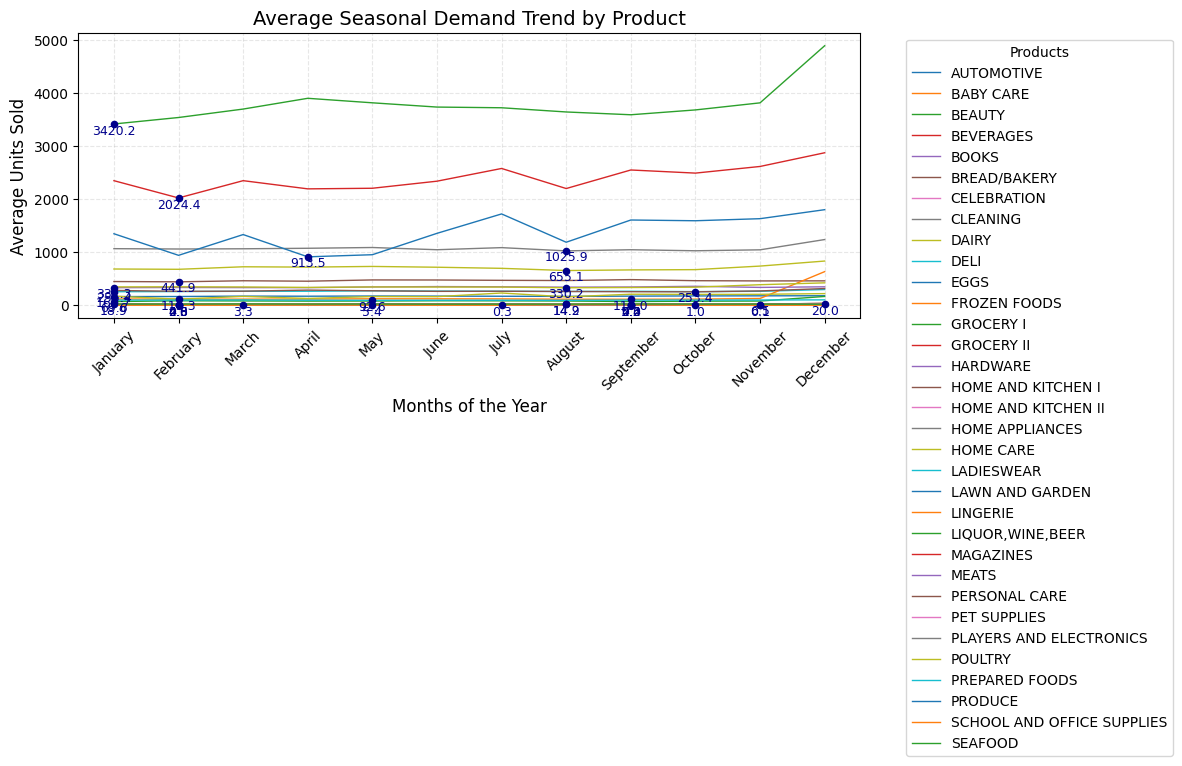

In [9]:
plt.figure(figsize=(12,6))
for product in seasonal.columns:
    plt.plot(seasonal.index, seasonal[product], linewidth=1, label=product)

    # Find the min month + min value for this product
    min_month = seasonal[product].idxmin()
    min_value = seasonal[product].min()

    # Highlight with scatter
    plt.scatter(min_month, min_value, color="darkblue", s=20, zorder=5)

    # Annotate the min spike
    plt.text(min_month, min_value, f"{min_value:.1f}",
             ha="center", va="top", fontsize=9, color="darkblue")

plt.xlabel("Months of the Year", fontsize=12)
plt.ylabel("Average Units Sold", fontsize=12)
plt.title("Average Seasonal Demand Trend by Product", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend(title="Products", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Metrics

In [10]:
def calc_mae(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    "Calculates Mean Absolute Error"
    return float(np.abs(y_true - y_pred).mean())


def calc_wape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    "Calculates Weighted Absolute Percentage Error"
    denom = np.abs(y_true).sum() + 1e-8
    return float(np.abs(y_true - y_pred).sum() / denom)


def calc_smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    "Calculates Symmetric Mean Absolute Percentage Error"
    denom = (np.abs(y_true) + np.abs(y_pred)) + 1e-8
    return float((2.0 * np.abs(y_true - y_pred) / denom).mean())


def compute_metrics(y_true, y_pred):
    """
    Metric computation for classification tasks.
    MAE, WAPE, sMAPE
    Computes ROC AUC and PR AUC using continuous scores.
    """
    y_true = np.concatenate(y_true, axis=0)
    y_pred = np.concatenate(y_pred, axis=0)

    metrics = {}
    metrics["mae"] = calc_mae(y_true, y_pred)
    metrics["wape"] = calc_wape(y_true, y_pred)
    metrics["smape"] = calc_smape(y_true, y_pred)

    return metrics

# ARIMA

In [11]:
# Group by Product and Date (monthly resample)
ts = (
    df.groupby(['family', pd.Grouper(key='date')])['sales']
    .sum()
    .reset_index()
)

In [12]:
def get_prod_data(prod_name):
  data = ts[ts['family'] == prod_name].copy()
  data.drop('family', axis=1, inplace=True)

  # Make sure Units Sold is numeric
  data['sales'] = pd.to_numeric(data['sales'], errors='coerce')

  # --- Ensure datetime format and sorting ---
  data['date'] = pd.to_datetime(data['date'])
  data = data.sort_values('date')
  data.set_index('date', inplace=True)
  data = data.asfreq('D').fillna(0)

  # Split data into train and test
  train_size = int(len(data) * 0.8)
  train, test = data.iloc[:train_size], data.iloc[train_size:]
  return train, test

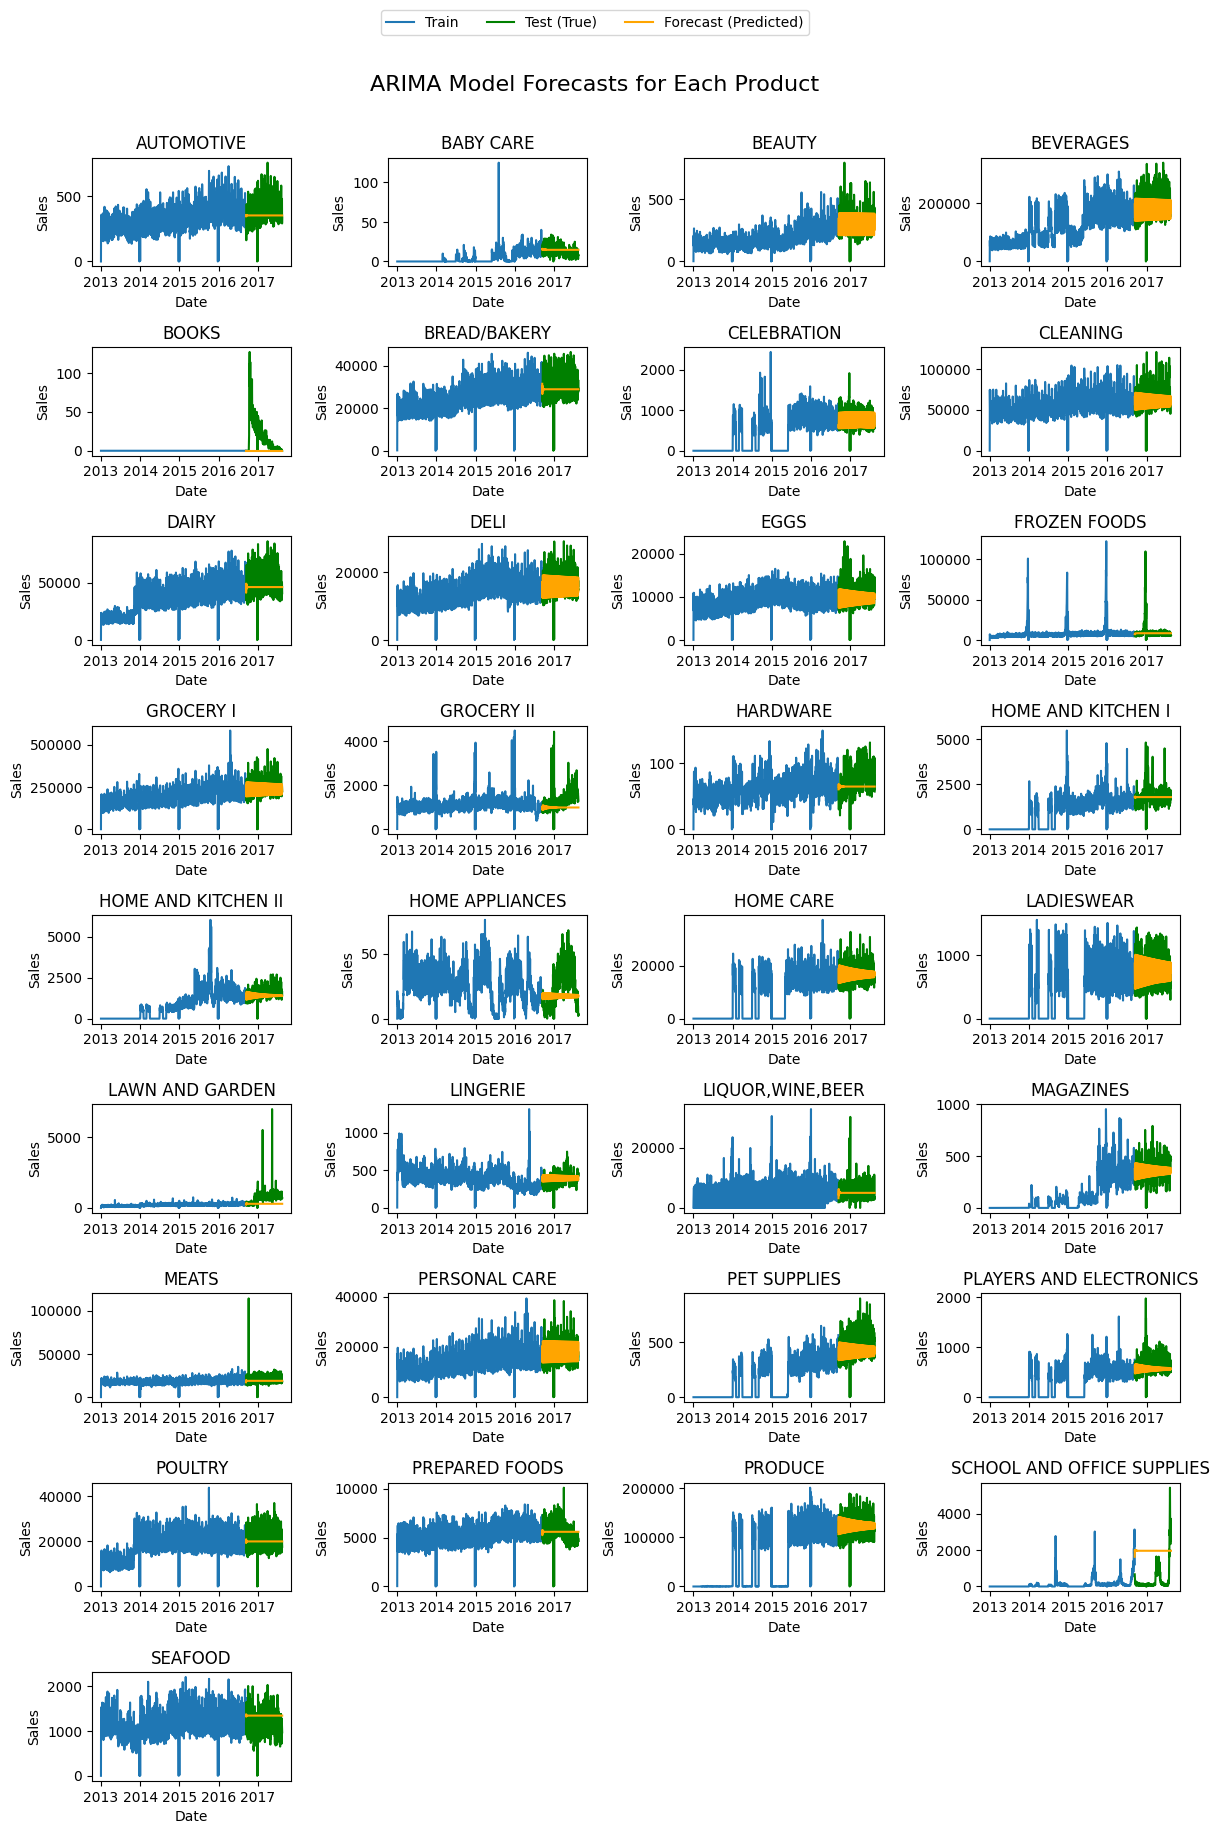

Overall MAE: 4175.6045
Overall WAPE: 0.1630
Overall SMAPE: 0.3366


In [13]:
y_true = []
y_pred = []

prod_names = list(ts['family'].unique())
n_products = len(prod_names)
n_cols = 4  # Number of columns in the subplot grid
n_rows = math.ceil(n_products / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2 * n_rows), sharex=False)
plt.suptitle("ARIMA Model Forecasts for Each Product\n\n", fontsize=16)
axes = axes.flatten()  # Flatten in case of single row

for idx, prod_name in enumerate(prod_names):
    train, test = get_prod_data(prod_name)
    model = ARIMA(train['sales'], order=(2,1,3))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=len(test))

    ax = axes[idx]
    # Only add labels for the first subplot
    if idx == 0:
        ax.plot(train.index, train['sales'], label="Train")
        ax.plot(test.index, test['sales'], label="Test (True)", color="green")
        ax.plot(test.index, forecast, label="Forecast (Predicted)", color="orange")
    else:
        ax.plot(train.index, train['sales'])
        ax.plot(test.index, test['sales'], color="green")
        ax.plot(test.index, forecast, color="orange")
    ax.set_title(f"{prod_name}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")

    y_true.append(test['sales'].values)
    y_pred.append(forecast.values)

# Hide any unused subplots
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a single legend for the whole figure
fig.legend(["Train", "Test (True)", "Forecast (Predicted)"], loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))
plt.tight_layout()
plt.show()

metrics = compute_metrics(y_true, y_pred)
print(f"Overall MAE: {metrics['mae']:.4f}")
print(f"Overall WAPE: {metrics['wape']:.4f}")
print(f"Overall SMAPE: {metrics['smape']:.4f}")

# Linear Regression

In [14]:
# Linear Regression with Multiple Features
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


# Load the merged dataset
# (Change the path if needed)
data_path = "eda/train_merged.csv"
df = pd.read_csv(data_path)

# --- Feature Engineering ---
# Convert date to datetime and extract useful features
df['date'] = pd.to_datetime(df['date'])
df['dayofweek'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year

# Encode categorical variables using one-hot encoding
categorical_cols = [
    'family', 'day_type', 'day_locale', 'day_locale_name', 'day_description',
    'store_city', 'store_state', 'store_type'
]
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Select features and target
feature_cols = [
    'store_nbr', 'onpromotion', 'oil_price', 'store_cluster', 'day_transferred',
    'dayofweek', 'month', 'year'
] + [col for col in df_encoded.columns if any(cat in col for cat in categorical_cols) and col != 'family']

X = df_encoded[feature_cols]
y = df_encoded['sales']

# Split into train, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Fit Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
test_pred = lr.predict(X_test)
y_true = [y_test.values]
y_pred = [test_pred]

metrics = compute_metrics(y_true, y_pred)

print(f"MAE: {metrics['mae']:.4f} | WAPE: {metrics['wape']:.4f} | SMAPE: {metrics['smape']:.4f}")

MAE: 315.7444 | WAPE: 0.8446 | SMAPE: 1.4174
